# Modelo A

Autor: Daniel Triviño

# Índice

+ [Setup del cuaderno](#setup-del-cuaderno)
+ Sección 2: Entendimiento de datos y preprocesamiento
    + [Calidad de los datos](#calidad-de-los-datos)
    + [Perfilamiento de los datos](#perfilamiento-de-los-datos)
    + [Preparación de los datos](#seccion-2---preparacion-de-datos)
+ Sección 3: Creación y evaluación de un modelo
    + [Entrenamiento de un Decision Tree](#seccion-3---entrenamiento-de-un-decision-tree)
    + [Entrenamiento de un Random Forest](#seccion-3---entrenamiento-de-un-random-forest)
        + [Evaluación del training set](#training-set-evaluation)
        + [Evaluación del test set](#test-set-evaluation)
    + [Construcción de un pipeline](#seccion-3---construccion-de-pipeline-de-prediccion)
    + [Prueba de pipeline con train-test split](#seccion-3---prueba-de-pipeline-con-train-test-split)
    + [Prueba de pipeline con Cross Validation](#seccion-3---prueba-de-pipeline-con-cv-y-gridsearch)
+ [Sección 4: Prueba del pipeline sobre el dataset de test no etiquetado](#seccion-4---prueba-de-pipeline-con-dataset-de-prueba-final-y-exportacion-de-csv--xlsx-resultante)
+ [Serialización del modelo](#serializar-modelo)


# Setup del cuaderno

In [64]:
import pandas as pd
from ydata_profiling import ProfileReport
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib

# import word tokenize
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer,
    HashingVectorizer,
)

nltk.download("punkt_tab")
import spacy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import joblib
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Load the large spanish model
nlp = spacy.load("es_core_news_lg")
# nlp = spacy.load('es_dep_news_trf')
%matplotlib inline

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Seccion 2 - Entendimiento de los datos

In [65]:
df_original = pd.read_csv('C:/Users/danie/Projects/BI_PROY1_2402/Proyecto 1/Etapa 1/Datasets/ODScat_345.csv', encoding='utf-8')
df_test_original = pd.read_excel('C:/Users/danie/Projects/BI_PROY1_2402/Proyecto 1/Etapa 1/Datasets/TestODScat_345.xlsx')

In [66]:
df_original

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


## Calidad de los datos

Dimensiones de calidad de los datos:
+ Consistencia
+ Validez
+ Completitud
+ Unicidad

### Completitud

Bajo una inspección sencilla, parece no haber problemas de completitud en los datos

In [67]:
df_original['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

In [68]:
# strip all values in the column
df_original['Textos_espanol'] = df_original['Textos_espanol'].str.strip()
# count all values in the column where the value is an empty string

df_original['Textos_espanol'].isnull().sum()

0

### Validez

Se identifican los siguietnes problemas de validez:
+ Hay un problema de codificación de los textos en el dataset, pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [69]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

df_original['Textos_espanol'] = df_original['Textos_espanol'].apply(fix_encoding)

In [70]:
df_original.head(5)

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


### Consistencia

Algunas de las entradas de texto del dataset están rodeadas por comillas dobles, aunque no todas. Es posible que esto no introduzca problemas en el dataset. 

### Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece no haber filas totalmente duplicadas.

In [71]:
df_original.duplicated().sum()

0

## Perfilamiento de los datos

Se aprovecha el paquete ydata-profiling para hacer un perfilamiento detallado del dataset. A partir de este reporte se destacan las siguientes conclusiones:
+ Variables: 2
+ Observaciones: 4049

|Variable|Tipo|
|--|--|
|Textos_espanol|Text|
|sdg|Categórica|

+ Se observa con ayuda del wordcloud que las palabras mas frecuentes en el dataset son stopwords que podrían ser eliminadas en el paso de procesamiento de datos. 


In [72]:
profile = ProfileReport(df_original, title="Profiling Report")
profile.to_file("./data_profiling.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Seccion 2 - Preparacion de datos

In [73]:
df_limpieza = df_original.copy(deep=True)
def word_tokenize_spanish(text):
    return word_tokenize(text, language='spanish')
df_limpieza['words'] = df_limpieza['Textos_espanol'].apply(word_tokenize_spanish)
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[Por, ejemplo, ,, el, número, de, consultas, e..."
1,"En 2007, el gobierno central financió directam...",3,"[En, 2007, ,, el, gobierno, central, financió,..."
2,"Claramente, hay muchos otros factores en juego...",3,"[Claramente, ,, hay, muchos, otros, factores, ..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[Por, ejemplo, ,, el, estado, australiano, de,..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[El, consumo, anual, de, alcohol, se, estima, ..."


In [74]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalpha()]

def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

def preprocessing(words: list[str]):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

In [75]:
df_limpieza['words'] = df_limpieza['words'].apply(preprocessing)
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financió, directamente, so..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estima, litros, año,..."


In [76]:
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financió, directamente, so..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estima, litros, año,..."


In [77]:
# word cloud
text = ''
for word_list in df_limpieza['words']:
    text += ' '.join(word_list) + ' '

# text = 'monda'

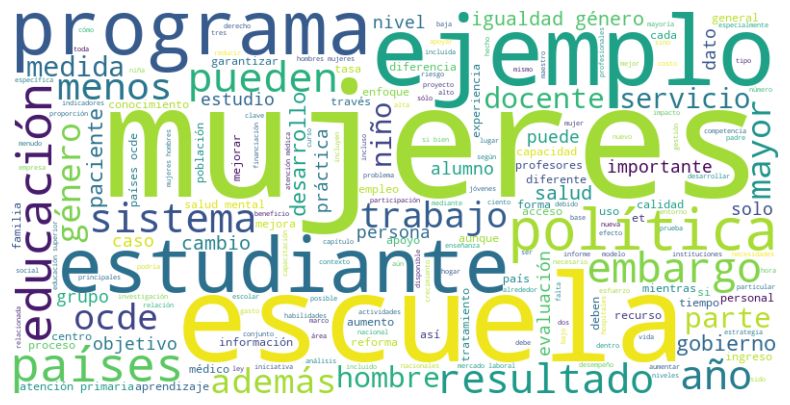

In [78]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [79]:
def lemmatize(words):
    text = ' '.join(words)
    doc = nlp(text)
    return [token.lemma_ for token in doc]

def stem(words):
    stemmer = nltk.stem.SnowballStemmer('spanish')
    words = [stemmer.stem(word) for word in words]
    return words

def stem_and_lemmatize(words: list[str]):
    # words = stem(words)
    words = lemmatize(words)
    return words


In [80]:
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consultas, externas, especia..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financió, directamente, so..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factores, juego, particular, vari..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, creó, agencia..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estima, litros, año,..."


In [81]:
df_limpieza['words'] = df_limpieza['words'].apply(stem_and_lemmatize)

In [82]:
df_limpieza.head(5)

,Textos_espanol,sdg,words
0,"Por ejemplo, el número de consultas externas d...",3,"[ejemplo, número, consulta, externo, especiali..."
1,"En 2007, el gobierno central financió directam...",3,"[gobierno, central, financiar, directamente, s..."
2,"Claramente, hay muchos otros factores en juego...",3,"[claramente, factor, juego, particular, varied..."
3,"Por ejemplo, el estado australiano de Victoria...",3,"[ejemplo, australiano, victoria, crear, agenci..."
4,"El consumo anual de alcohol se estima en 15,7 ...",3,"[consumo, anual, alcohol, estimar, litro, año,..."


In [83]:
df_limpieza['final_text'] = df_limpieza['words'].apply(lambda x: ' '.join(map(str, x)))
X_data, y_data = df_limpieza['final_text'],df_limpieza['sdg']
count = CountVectorizer()
X_count = count.fit_transform(X_data)
print(X_count.shape)
X_count

(4049, 12449)


<4049x12449 sparse matrix of type '<class 'numpy.int64'>'
	with 187434 stored elements in Compressed Sparse Row format>

## Visualización de palabras relevantes por categoría

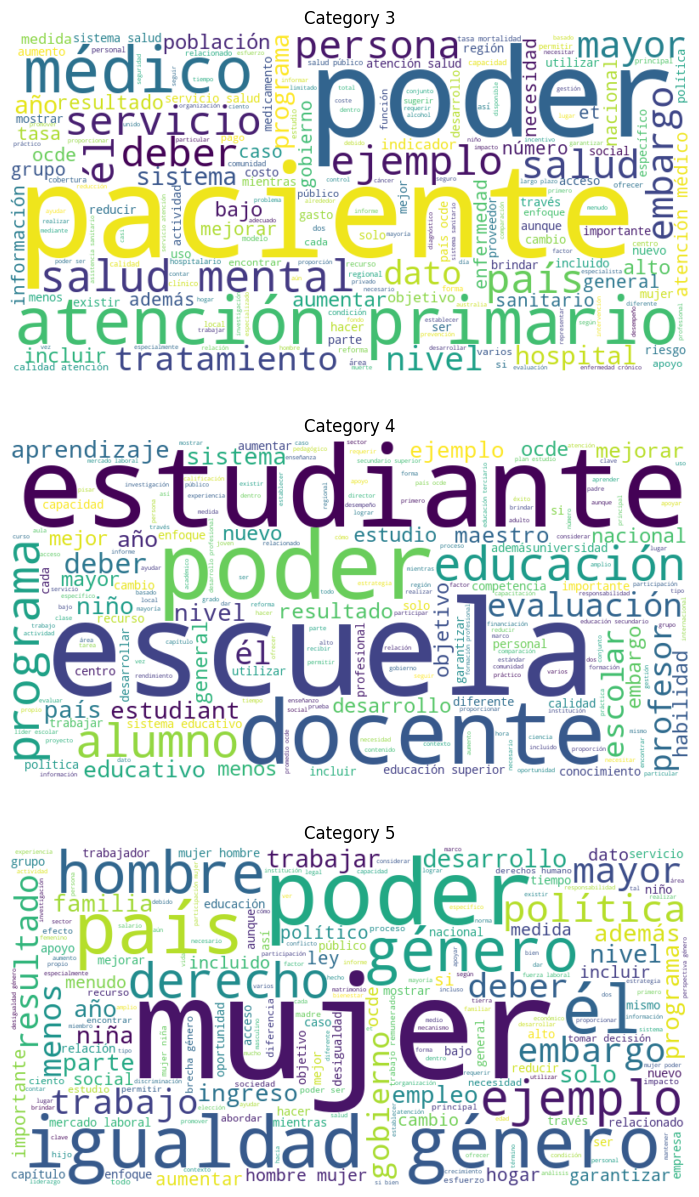

In [84]:
df_cat_3 = df_limpieza[df_limpieza['sdg'] == 3]
# cat 4
df_cat_4 = df_limpieza[df_limpieza['sdg'] == 4]
# cat 5
df_cat_5 = df_limpieza[df_limpieza['sdg'] == 5]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

def plot_word_cloud_by_cat(df, ax, category, index):
    text = df['final_text'].str.cat(sep=' ')
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax[index].imshow(wordcloud, interpolation='bilinear')
    ax[index].axis('off')
    ax[index].set_title(f'Category {category}')

plot_word_cloud_by_cat(df_cat_3, ax, 3, 0)
plot_word_cloud_by_cat(df_cat_4, ax, 4, 1)
plot_word_cloud_by_cat(df_cat_5, ax, 5, 2)


plt.show()

In [85]:
X = pd.DataFrame(X_count.toarray(), columns=count.get_feature_names_out())
X['texto_original'] = df_limpieza['Textos_espanol']

In [86]:
for p in X.columns:
    print(p)

aalto
aaltonar
aarkrog
aarrevaaro
abajo
abanderado
abandonado
abandonar
abandono
abanico
abarcada
abarcar
abbas
abbasian
abbott
abc
abdullah
abiertamente
abierto
abitur
abiyán
abogada
abogado
abogar
abolición
abolido
abolir
abonado
abordada
abordado
abordaje
abordar
abordarla
abordarlos
aborigen
abortir
aborto
aborígenes
aborígén
abouchaar
about
abp
abreviadamente
abriac
abril
abrir
abrumado
abrumador
abruptamente
abrupto
absentismo
absoluto
absolutos
absorber
absorción
absorr
abstemio
abstener
abstracto
abu
abuela
abuelos
abuja
aburrido
aburrimiento
abusada
abusado
abusador
abusar
abusivo
abuso
abyecto
acabar
academia
académicamente
académico
académique
acamo
acar
acaro
acarrear
acceder
accedido
accenture
accesibilidad
accesibl
accesible
acceso
access
accident
accidental
accidente
accionista
acción
accra
accrott
ace
acecho
aceitero
aceleración
acelerar
acemoglu
acentuado
acentuar
aceptabilidad
aceptable
aceptación
aceptado
aceptar
acerca
acercar
acertadamente
acertado
achacar
achievem

# Seccion 3 - Entrenamiento de un Decision Tree

In [87]:
# Import a decision tree
# Split the data into a training and a test set
from pandas import DataFrame


training_data = X
training_data['category'] = y_data

y = training_data['category']

X_train, X_test, y_train, y_test = train_test_split(training_data.drop(['category'], axis=1), y, test_size=0.2, 
random_state=42)

X_train_texto_original = DataFrame(X_train['texto_original'], columns=['texto_original'])
X_test_texto_original = DataFrame(X_test['texto_original'], columns=['texto_original'])

X_train = X_train.drop(['texto_original'], axis=1)
X_test = X_test.drop(['texto_original'], axis=1)

# Create the decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict the test set
y_pred_test = clf.predict(X_test)

In [88]:
# Calculate the accuracy
accuracy_score(y_test, y_pred_test)

0.9444444444444444

In [89]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           3       0.92      0.96      0.94       250
           4       0.96      0.94      0.95       268
           5       0.95      0.94      0.95       292

    accuracy                           0.94       810
   macro avg       0.94      0.94      0.94       810
weighted avg       0.95      0.94      0.94       810



# Seccion 3 - Entrenamiento de un Random Forest

In [90]:
# Import a random forest

# Create the random forest
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predict the test set
y_pred_test = rf_clf.predict(X_test)

## Training set evaluation

In [91]:
# Evaluate with the training set
y_pred_train = rf_clf.predict(X_train)

# Calculate the accuracy
accuracy_score(y_train, y_pred_train)

print(classification_report(y_train, y_pred_train))


              precision    recall  f1-score   support

           3       1.00      1.00      1.00       994
           4       1.00      1.00      1.00      1086
           5       1.00      1.00      1.00      1159

    accuracy                           1.00      3239
   macro avg       1.00      1.00      1.00      3239
weighted avg       1.00      1.00      1.00      3239



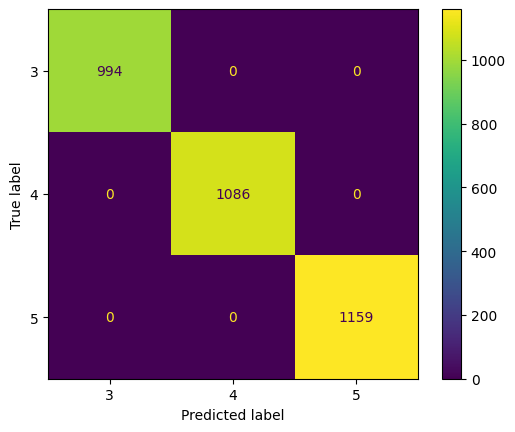

In [92]:
# Plot confussion matrix
cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [93]:
X_train_texto_original['category'] = y_train
X_train_texto_original['prediction'] = y_pred_train
X_train_texto_original['correct'] = X_train_texto_original['category'] == X_train_texto_original['prediction']
X_train_texto_original[X_train_texto_original['correct'] == False]

,texto_original,category,prediction,correct


## Test set Evaluation

In [94]:
# Calculate the accuracy
print(accuracy_score(y_test, y_pred_test))

print(classification_report(y_test, y_pred_test))

0.9765432098765432
              precision    recall  f1-score   support

           3       0.98      0.99      0.98       250
           4       0.97      0.98      0.97       268
           5       0.98      0.97      0.97       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



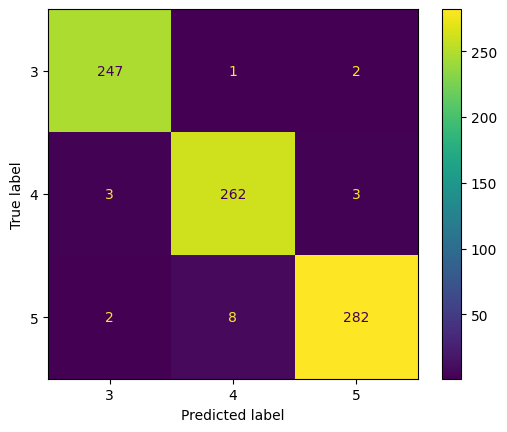

In [95]:
# Plot me a confusion matrix

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [96]:
# pd.set_option('display.max_colwidth', None)
X_test_texto_original['category'] = y_test
X_test_texto_original['prediction'] = y_pred_test
X_test_texto_original['correct'] = X_test_texto_original['category'] == X_test_texto_original['prediction']
X_test_texto_original[X_test_texto_original['correct'] == False].to_csv('failed_predictions.csv', index=True)
X_test_texto_original[X_test_texto_original['correct'] == False]

,texto_original,category,prediction,correct
1042,Los ingresos de los graduados con educación te...,4,5,False
1075,Uno de los mayores obstáculos a los que se enf...,4,5,False
3186,Las políticas para promover un entorno escolar...,5,4,False
2216,Este tema también ha sido destacado por la Red...,5,4,False
2658,"Los maestros, administradores y estudiantes pu...",5,4,False
1764,International Handbook on the Preparation and ...,4,3,False
2736,Los gobiernos africanos deben abordar el desaf...,5,4,False
594,El programa se basaba en la integración estrat...,3,4,False
3624,"En cuanto a estudios realizados en la región, ...",5,3,False
174,"En 2012, el 48,4% de las muertes fueron de muj...",3,5,False


# Seccion 3 - Construccion de pipeline de prediccion

In [97]:
# Construct a pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Pasos del pipeline
# 1. Strip
# 2. Fix encoding
# 3. Tokenize
# 4. Preprocessing
# 5. Lemmatize
# 6. Concatenate words
# 7. Count Vectorizer
# 8. Random Forest Classifier

# 1. Strip
def strip_text(X):
    return X.str.strip()

# 2. Fix encoding
def replace(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    return text

def fix_encoding_array(X):
    return X.apply(replace)

# 3. Tokenize
def word_tokenize_spanish(text):
    return word_tokenize(text, language='spanish')

def word_tokenize_spanish_array(X):
    X = X.apply(word_tokenize_spanish)
    return X

# 4. Preprocessing
def to_lower(words: list[str]):
    return [word.lower() for word in words]

def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalpha()]

def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

def preprocessing(words: list[str]):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

def preprocessing_array(X):
    return X.apply(preprocessing)

# 5. Lemmatize
# Load the large spanish model

def lemmatize(words, nlp):
    text = ' '.join(words)
    doc = nlp(text)
    return [token.lemma_ for token in doc]

def lemmatize_array(X):
    nlp = spacy.load("es_core_news_lg")
    return X.apply(lemmatize, nlp=nlp)

# 6. Concatenate words
def concat_words(words):
    return ' '.join(map(str, words))

def concat_words_array(X):
    return X.apply(concat_words)

# 7. Count Vectorizer
# def vectorize(X):
#     count = CountVectorizer()
#     X_count = count.fit_transform(X)
#     X_count = pd.DataFrame(X_count.toarray(), columns=count.get_feature_names_out())
#     return X_count

preprocessing_pipeline = Pipeline([
    ('strip', FunctionTransformer(strip_text)),
    ('fix_encoding', FunctionTransformer(fix_encoding_array)),
    ('tokenize', FunctionTransformer(word_tokenize_spanish_array)),
    ('preprocessing', FunctionTransformer(preprocessing_array)),
    ('lemmatize', FunctionTransformer(lemmatize_array))
])

vectorization_clf_pipeline = Pipeline([
    ('concat', FunctionTransformer(concat_words_array)),
    ('b_o_w', CountVectorizer(max_features=6500)),
    ('clf', RandomForestClassifier(random_state=42, n_estimators=200, max_depth=None, criterion='gini', bootstrap=True))
])

pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('vectorization_clf', vectorization_clf_pipeline)
])

# Seccion 3 - Prueba de pipeline con train-test split

In [98]:
df_original = pd.read_excel('../Datasets/ODScat_345.xlsx')

In [99]:
random_state = 42 # Se usó el random_state 42 para la presentación de resulatdos
X_train, X_test, y_train, y_test = train_test_split(
    df_original["Textos_espanol"], df_original["sdg"], test_size=0.2, random_state= random_state
)
y_pred_test = pipeline.fit(X_train, y_train).predict(X_test)
print(accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

0.9740740740740741
              precision    recall  f1-score   support

           3       0.98      0.98      0.98       250
           4       0.97      0.97      0.97       268
           5       0.98      0.97      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



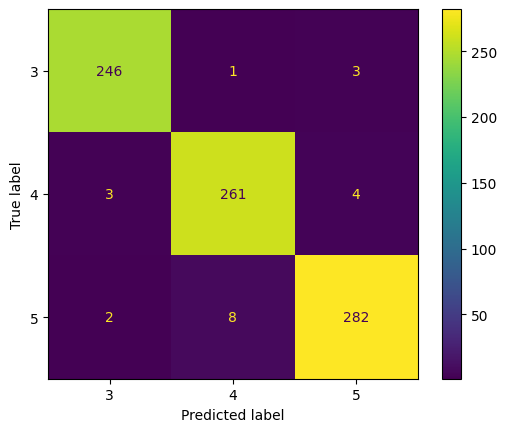

In [100]:
# Plot confussion matrix
clf = pipeline.named_steps['vectorization_clf'].named_steps['clf']
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## Extracción de palabras más importantes

In [101]:
importancia = pipeline.named_steps['vectorization_clf'].named_steps['clf'].feature_importances_
features = pipeline.named_steps['vectorization_clf'].named_steps['b_o_w'].get_feature_names_out()
corpus_size = len(features)
importancia_atributo = pd.DataFrame(data={"Atributo": features,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

In [102]:

# get n rows so that the sum of the importance is greater than 0.8
n = 0
sum_importance = 0
while sum_importance < 0.9999:
    sum_importance += importancia_atributo['Importancia'][n]
    n += 1
print(len(features))
print(n)
print(importancia_atributo.head(n)['Importancia'].sum())
most_important_words = importancia_atributo.head(n)['Atributo'].values
print(most_important_words)

6500
5381
0.9999004492376873
['mujer' 'género' 'salud' ... 'empezado' 'presumiblemente' 'experiencio']


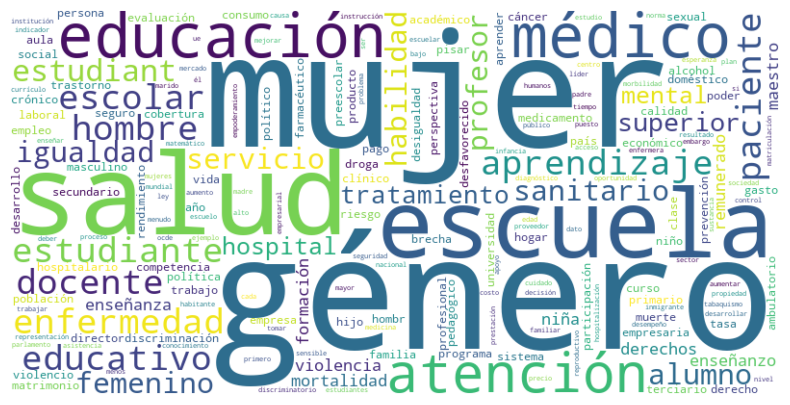

In [103]:
# make a wordcloud
# text = ' '.join(most_important_words)
word_freq = Counter()
total_words = len(most_important_words)
for position, word in enumerate(most_important_words):
    weight = total_words - position  # Higher weight for earlier positions
    word_freq[word] += weight
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Seccion 3 - Prueba de pipeline con CV y gridsearch

## Validación cruzada

In [104]:
particiones = KFold(n_splits=10, shuffle=True, random_state = 42)

# Perform cross validation
X = df_original["Textos_espanol"]
X = preprocessing_pipeline.transform(X)
y = df_original["sdg"]
scores = cross_val_score(vectorization_clf_pipeline, X, y, cv=particiones)

In [105]:
print(scores)
print(f"Scores mean: {scores.mean()}")


[0.9654321  0.97530864 0.98271605 0.97283951 0.97530864 0.9654321
 0.98024691 0.98271605 0.97530864 0.97029703]
Scores mean: 0.974560567167828


## Grid Search

In [106]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy', 'log_loss']   
}
X = df_original["Textos_espanol"]
y = df_original["sdg"]

X = preprocessing_pipeline.transform(X)
X = concat_words_array(X)
X = CountVectorizer(max_features=6500).fit_transform(X)
# X = TfidfVectorizer().fit_transform(X)

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [107]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 200}
Best cross-validation score: 0.9741


# Seccion 4 - Prueba de pipeline con dataset de prueba final y exportacion de csv / xlsx resultante

In [108]:
df_original = pd.read_excel('C:/Users/danie/Projects/BI_PROY1_2402/Proyecto 1/Etapa 1/Datasets/ODScat_345.xlsx')
X_data = df_original['Textos_espanol']
y_data = df_original['sdg']

In [109]:
X_data = df_original['Textos_espanol']
y_full = df_original['sdg']
y_pred_full = pipeline.fit(X_data, y_full).predict(X_data)

In [110]:
df_test_original = pd.read_excel('../Datasets/TestODScat_345.xlsx')

In [111]:
X_test = df_test_original['Textos_espanol']
y_pred_test = pipeline.predict(X_test)

In [114]:
df_test_original['sdg'] = y_pred_test
df_test_original.to_excel('../Data Outputs/modelo_a.xlsx', index=False)
df_test_original.to_csv('../Data Outputs/modelo_a.csv', index=False)

# Serializar modelo

In [113]:
# Serialize model
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']